In [24]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from flowtensor import Convolution2D
from keras.layers import Conv2D, MaxPool2D, Dense

%matplotlib inline

In [25]:
??Dense

In [10]:
def padding(img, pad):
    img_pad = np.pad(img, ((pad, pad), (pad,pad)), 'constant', constant_values=0)
    
    return img_pad

In [11]:
class Convolution2D:
    def __init__(self, filter_shape, num_filters, padding, stride, activation='relu', kernel_init='None'):
        self.filter_shape = filter_shape
        self.num_filters = num_filters
        self.padding = padding
        self.stride = stride
        self.activation = activation
        self.kernel_init = kernel_init
        
        # random kernel initialization
        if self.kernel_init.lower() == 'none':
            self.filters = np.random.randn(num_filters, filter_shape[0], filter_shape[0])
        # xavier kernel initialization a.k.a glorot normal
        elif self.kernel_init.lower() == 'xavier':
            self.filters = np.random.randn(num_filters, filter_shape[0], filter_shape[0]) / 9 # 1 / N
        
    def iterate(self, img, filter_shape):
        height, width = img.shape
        height = int((height + 2 * self.pad_size - self.filter_shape[0]) / self.stride) + 1
        width = int((width + 2 * self.pad_size - self.filter_shape[0]) / self.stride) + 1
        # check for odd heights and widths
        if height % 2 != 0 and width % 2 != 0:
            height += 1
            width += 1
#         print(height)
#         print(width)
#         print(filter_shape[0]-1)
        
        for i in range(height-(filter_shape[0]-1)):
            for j in range(width-(filter_shape[0]-1)):
#                 i_start = i * self.stride
#                 i_end = i_start + filter_shape[0]
#                 j_start = j * self.stride
#                 j_end = j_start * filter_shape[0]
#                 output = img[i_start:i_end, j_start:j_end]
                output = img[i*self.stride:(i*self.stride+filter_shape[0]), j*self.stride:(j*self.stride+filter_shape[0])]
#                 print(output, i, j)
                yield output, i, j # 'yield' keyword will return any values and continue from the last value returned
    
    def conv2d(self, inputs):
#         print("Before padding: ", inputs.shape)
        self.last_input = inputs # cache the last input for backpropagation
    
        # padding
        if(self.padding.lower() == 'same'): # same padding
            height, width = inputs.shape
            
            pad_size = int(((height * self.stride) - height + self.filter_shape[0] - 1) / 2)
            self.pad_size = pad_size

            inputs = padding(inputs, pad_size) # apply padding according to the pad_size
            height, width = inputs.shape # reinitialize height and width with padded image

            new_height = int((height + 2 * pad_size - self.filter_shape[0]) / self.stride) + 1
            new_width = int((width + 2 * pad_size - self.filter_shape[0]) / self.stride) + 1
            # check for odd heights and widths
            if new_height % 2 != 0 and new_width % 2 != 0:
                new_height += 1
                new_width += 1
                
            output = np.zeros((new_height, new_width, self.num_filters))
            
        elif(self.padding.lower() == 'valid'): # valid/no padding
            height, width = inputs.shape
            self.pad_size = 0
            output = np.zeros((height-(self.filter_shape[0]-1), width-(self.filter_shape[0]-1), self.num_filters))
            
#         print("After padding: ", inputs.shape)
        
        for region, i, j in self.iterate(inputs, self.filter_shape):
            output[i, j] = np.sum(region * self.filters, axis=(1,2))
            if self.activation.lower() == 'relu':
                output[i, j] = np.maximum(0, output[i, j])
        
#         print("After convolution: ", output.shape)
        return output

    def back_propagation(self, dL, learning_rate):
        dL_filters = np.zeros(self.filters.shape)
        
        for img_region, i, j in self.iterate(self.last_input, self.filter_shape):
            for k in range(self.num_filters):
                dL_filters[k] += dL[i, j, k] * img_region
        
        # don't forget to update the filters
        self.filters -= learning_rate * dL_filters
        
        return None

In [12]:
class MaxPool2D:
    def __init__(self, pool_size):
        self.pool_size = pool_size
    
    def iterate(self, img):
        height, width, _ = img.shape
        h = height//self.pool_size
        w = width//self.pool_size
        
        for i in range(h):
            for j in range(w):
                new_region = img[(i*self.pool_size):(i*self.pool_size+self.pool_size), 
                                 (j*self.pool_size):(j*self.pool_size+self.pool_size)]
                yield new_region, i, j
    
    def pool(self, inputs):
        self.last_input = inputs # cache the last input for backpropagation
        
        height, width, num_filters = inputs.shape
        output = np.zeros((height//self.pool_size, width//self.pool_size, num_filters))
        
        for img_region, i, j in self.iterate(inputs):
            output[i, j] = np.max(img_region, axis=(0,1))
        
#         print("After pooling: ", output.shape)
        return output
    
    # backpropagation
    def back_propagation(self, dL_output):
        dL_input = np.zeros((self.last_input.shape))
        
        for img_region, i, j in self.iterate(self.last_input):
            height, width, num_filters = img_region.shape
            # find the max value for each region
            maxi = np.max(img_region, axis=(0,1))
            
            for k in range(height):
                for l in range(width):
                    for m in range(num_filters):
                        if img_region[k, l, m] == maxi[m]: # if the max values match, copy the gradient
                            dL_input[i*2+k, j*2+l, m] = dL_output[i, j, m]
        return dL_input

In [13]:
class Softmax:
    # initialize random weights and zero biases
    def __init__(self, num_features, num_nodes, activation, regularizer='None'):
        self.weights = np.random.randn(num_features, num_nodes) / num_features
        self.biases = np.zeros(num_nodes)
        self.activation = activation
        self.regularizer = regularizer
#         print(self.weights.shape)
#         print(self.biases.shape)
    
    # flattens out the previous layer
    def flatten(self, inputs):
        self.inputs = inputs.flatten()
#         print(self.inputs.shape)
    
    # connects flattened layer with a fully connected layer (dense)
    def dense(self, inputs):
        self.last_input_shape = inputs.shape # cache the last input shape BEFORE FLATTENING
        
        inputs = inputs.flatten() # flatten
        self.last_input = inputs # cache the last input shape AFTER FLATTENING
        input_features, nodes = self.weights.shape
        
        z = np.dot(inputs, self.weights) + self.biases # z = W . X + b
        self.z = z # cache z for backpropagation
        
        if(self.activation.lower() == 'softmax'):    
            a = np.exp(z) # a = g(z)
            return a / np.sum(a, axis=0) # e^a / sum(a)
        elif(self.activation.lower() == 'relu'):
            return max(0, z)
    
    # forward propagate phase
    def forward_propagation(self, img, label, output, reg_lambda=1e-2):
        # -log(x) --> softmax loss function
        loss = (-np.log(output[label]))
        if self.regularizer.lower() == 'l2':
            loss += (1/2 * reg_lambda * np.sum(self.weights ** 2)) # + regularization term
        acc = 1 if np.argmax(output) == label else 0 # increase the accuracy if the predicted label = actual label

        return output, loss, acc
    
    def back_propagation(self, dL, learning_rate, reg_lambda=1e-2):
        for i, grad in enumerate(dL):
            if grad == 0: continue; # ignores 0 gradient
            
            exp_total = np.exp(self.z) # total of e^
            exp_sum = np.sum(exp_total) # sum of e^
            
            # gradients of z against totals
            dz = -exp_total[i] * exp_total / (exp_sum ** 2)
            dz[i] = exp_total[i] * (exp_sum - exp_total[i]) / (exp_sum ** 2)
            
            # gradients of totals against weights, biases, inputs
            dt_dw = self.last_input
            dt_db = 1
            dt_di = self.weights
            
            # gradients of loss against totals
            dL_dt = grad * dz
            
            # gradients of loss against weights, biases, and inputs
            dL_dw = np.dot(dt_dw[np.newaxis].T, dL_dt[np.newaxis])
            dL_db = dL_dt * dt_db
            dL_di = np.dot(dt_di, dL_dt)
            
            # add the regularization term
            dL_dw += reg_lambda * self.weights
            
            # update weights and biases
            self.weights -= learning_rate * dL_dw
            self.biases -= learning_rate * dL_db
            
            return dL_di.reshape(self.last_input_shape)

In [14]:
def load_data():
    (x1, y1), (x2, y2) = mnist.load_data()
    return (x1, y1), (x2, y2)

In [15]:
# load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# create helper objects
convolution = Convolution2D(filter_shape=(3,3), num_filters=8, padding='valid', stride=1, kernel_init='none')
maxpool = MaxPool2D(pool_size=2)
temp = convolution.conv2d(x_train[0]/255) # save img dimensions
temp = maxpool.pool(temp)
tmp_shape = temp.shape
softmax = Softmax(tmp_shape[0]*tmp_shape[1]*tmp_shape[2], 10, activation='softmax')

x_train[0].shape

(28, 28)

In [16]:
def build_model(image):
    # initialize the architecture
    model = convolution.conv2d(image/255)
    model = maxpool.pool(model)
    model = softmax.dense(model)
    
    return model

def compile_model(img, label, learning_rate):
    
    # initialize model
    train_model = build_model(img)

    # forward propagation step
    output, loss, acc = softmax.forward_propagation(img, label, train_model)
    
    # initial gradient
    grad = np.zeros(10) # 10 different classes
    grad[label] = -1 / output[label]
    
    # back propagation
    grad = softmax.back_propagation(grad, learning_rate)
    grad = maxpool.back_propagation(grad)
    grad = convolution.back_propagation(grad, learning_rate)
    
    return loss, acc


In [17]:
def train(epochs, lr):
    loss_dict = []
    acc_dict = []
    NUM_EPOCHS = epochs
    learning_rate = lr

    for epoch in range(NUM_EPOCHS):  
        print("============= EPOCH", epoch+1, "=============")
        total_loss = 0
        accuracy = 0

        for i, (img, label) in enumerate(zip(x_train[:1000], y_train[:1000])): # let's train first 1000 data for simplicity 
            # build the complete model
            if i % 100 == 0 and i != 0:
                print("Step", i, ": Loss= ", total_loss/100, "| Accuracy=", accuracy, "%")

                total_loss = 0
                accuracy = 0
            loss, acc = compile_model(img, label, learning_rate)
            total_loss += loss
            accuracy += acc
            
        loss_dict.append(total_loss)
        acc_dict.append(accuracy)
    
    return loss_dict, acc_dict

In [10]:
l, a = train(epochs=3, lr=0.01)

============= EPOCH 1 =============
Step 100 : Loss=  2.984689478021327 | Accuracy= 43 %
Step 200 : Loss=  1.146611120228385 | Accuracy= 69 %
Step 300 : Loss=  0.8850425011647629 | Accuracy= 73 %
Step 400 : Loss=  0.5756763192146644 | Accuracy= 81 %
Step 500 : Loss=  0.6720036640737765 | Accuracy= 77 %
Step 600 : Loss=  0.8132688859447772 | Accuracy= 74 %
Step 700 : Loss=  0.7683537382755885 | Accuracy= 85 %
Step 800 : Loss=  0.43624368220832743 | Accuracy= 88 %
Step 900 : Loss=  0.745984002722244 | Accuracy= 81 %
============= EPOCH 2 =============
Step 100 : Loss=  0.3429073853135956 | Accuracy= 90 %
Step 200 : Loss=  0.3624891984112184 | Accuracy= 92 %
Step 300 : Loss=  0.36073275403586075 | Accuracy= 87 %
Step 400 : Loss=  0.25597366233319935 | Accuracy= 92 %
Step 500 : Loss=  0.33847148794037407 | Accuracy= 90 %
Step 600 : Loss=  0.4398075115355131 | Accuracy= 85 %
Step 700 : Loss=  0.43114759774726347 | Accuracy= 91 %
Step 800 : Loss=  0.25403415227195275 | Accuracy= 93 %
Step 90

In [11]:
# test the model
def test(X_test, y_test):
    loss = 0
    accuracy = 0
    for img, label in zip(X_test, y_test):
        test_model = build_model(img)
        _, l, acc = softmax.forward_propagation(img, label, test_model, reg_lambda=1e-3)
        loss += l
        accuracy += acc

    print("Test Loss: ", loss/len(X_test))
    print("Test Accuracy: ", accuracy/len(y_test))

In [12]:
test(x_test[:1000], y_test[:1000])

Test Loss:  0.5822607528144069
Test Accuracy:  0.808


In [13]:
def show_loss_graph(l):
    plt.plot([i / 100 for i in l])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

In [14]:
def show_acc_graph(a):
    plt.plot(a)
    plt.title('Training Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

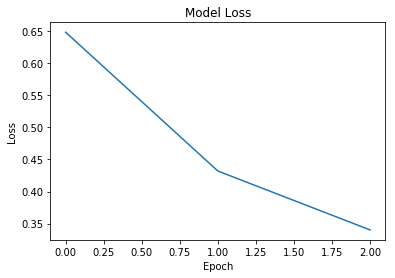

In [15]:
show_loss_graph(l)

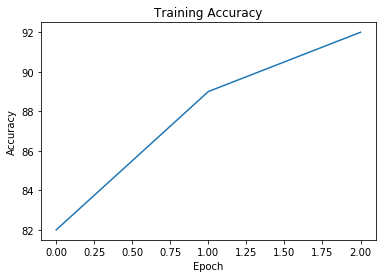

In [16]:
show_acc_graph(a)

In [34]:
def predict(img, label):
    test_model = build_model(img)
    pred, _, _ = softmax.forward_propagation(img, label, test_model, reg_lambda=1e-3)
    
    return np.argmax(pred)

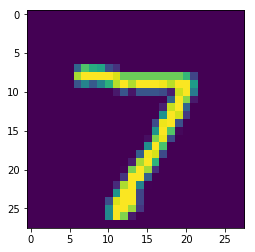

In [35]:
target_idx = 0
target = x_test[target_idx]
target_label = y_test[target_idx]

plt.imshow(target)

In [36]:
pred = predict(target, target_label)

In [37]:
pred

7